# Example: Open Image Dataset V4 subset as dataset for an application

This example shows:

- Building subset of Open Images Dataset V4 (OIDV4) by selecting annotations for simple application.
- Training a simple object detector model borrowed from fast.ai library lecture course.

From [fast.ai](https://www.fast.ai/)'s [Cutting Edge Deep Learning For Coders Part 2](https://course.fast.ai/part2.html), [pascal.ipynb](https://github.com/fastai/fastai/blob/master/courses/dl2/pascal.ipynb) is a course notebook that describes very intuitively how to build object detector from scratch.
It starts from training simple CNN classifier, then it replaces head of CNN model to predict a single bounding box and a class.

For training it, a largest bounding box is selected for an image where multiple bboxes are usually annotated.
This example shows how we can do that easily, as well as narrowing classes down to which application needs.

## Key takeaways

- Data selection by the size of bounding boxes or the classes we want for specific application.
- OIDV4 application by borrowing fast.ai example. * older fast.ai library (v0.7)
- Example of importance of data selection.

## Before you begin

- Create your annotation database described in [Open_Images_Dataset_V4_Starter.ipynb](Open_Images_Dataset_V4_Starter.ipynb).
- Install dl-cliche
```sh
$ pip install git+https://github.com/daisukelab/dl-cliche.git@master
```

In [1]:
from dlcliche.notebook import *
from od_anno import *

## Creating subset

Now start creating subset of OIDV4, that will have:
- 'Car' and 'Person' classes.
- Leave image's largest bounding box only, and drop all other smaller boxes.
- Trim `IsGroupOf`, `IsInside` items.
- Resize all images to 640x640.

Following uses folders/files below for explanation:
- You have original dataset under '/mnt/slow_dataset/oidv4'.
- You already have created database for that as 'annotations.csv'.
- Folder to create new subset dataset is '/mnt/dataset/suboidv4/car_person'.

In [2]:
# Subset path => PATH
PATH = Path('/mnt/dataset/suboidv4/car_person')
OIDV4 = Path('/mnt/slow_dataset/oidv4')

In [3]:
my_labels = ['Car', 'Person']

# Load raw ODAnno table.
od = ODAnno(OIDV4/'annotations.csv', OIDV4)
print(f'# of raw annotation labels = {len(od)}')

# Extract interested label only.
od.filter_by_label_(my_labels)
print(f'# of interested labels = {len(od)}')

# Filter smaller labels except largest.
od.filter_largest_()
print(f"# of image's biggset labels = {len(od)}")

# of raw annotation labels = 14610229
# of interested labels = 1282796
# of image's biggset labels = 329113


In [4]:
od.anno_df[:5]

,ImageID,File,Label,XMin,XMax,YMin,YMax,Width,Height,Rotation,Split,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside,Size
6,000002b66c9c498e,train/000002b66c9c498e.jpg,Person,0.41250,0.945312,0.120312,0.475000,1024.0,1024.0,0.0,train,1,0,1,0,0,0.188982
30,0000048549557964,train/0000048549557964.jpg,Car,0.43500,0.725625,0.698333,0.944167,1024.0,768.0,0.0,train,0,0,0,0,0,0.071446
63,0000071d71a0a6f6,train/0000071d71a0a6f6.jpg,Person,0.13875,0.522500,0.250000,0.998333,1024.0,768.0,0.0,train,1,1,0,0,0,0.287173
81,00001bcc92282a38,train/00001bcc92282a38.jpg,Person,0.00625,0.532500,0.084428,0.999062,1024.0,683.0,0.0,train,0,0,0,0,0,0.481326
97,000020780ccee28d,train/000020780ccee28d.jpg,Person,0.00000,0.262719,0.114375,0.680625,768.0,1024.0,0.0,train,0,1,0,0,0,0.148765


Total number of labels is huge 14M, and we still have too much 1.2M labels after dropping all other than Car and Person labels.
Then even after narrowing down again so that each image has only one label which has largest box, it still have 329k labels.

We need to narrow down more. Now let's check the data.

### Big bounding boxes (size > 0.6)

As you can see images of Person, it's not person but people. In OIDV4, it would be better to avoid big boxes.

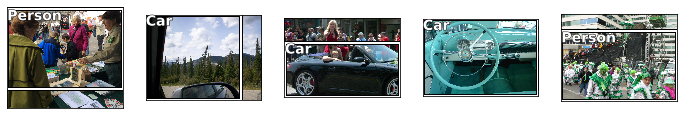

In [5]:
def image_ids(df): return list(df.ImageID)

ids = image_ids(od.anno_df[(0.6 < od.anno_df.Size)])
od.dataset(df=od.anno_df[od.anno_df.ImageID.isin(ids[100:105])]).show(range(5), matrixsize=(5,1), figsize=(12, 8))

### Small bounding boxes (size < 0.02)

There are also too small labels, not suitable for this example.

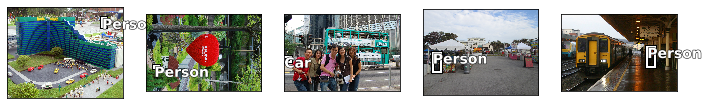

In [6]:
ids = image_ids(od.anno_df[(od.anno_df.Size < 0.02)])
od.dataset(df=od.anno_df[od.anno_df.ImageID.isin(ids[:5])]).show(range(5), matrixsize=(5,1), figsize=(12, 8))

### Modest size (0.3 < size < 0.4)

As shown above, while big labels are really big and almost same as image shape, small ones are too hard to detect.

After making similar check of different sizes, I came up with tentative setting `0.3 < size < 0.4` which has about 30k labels and less # of incorrect Person class labels.

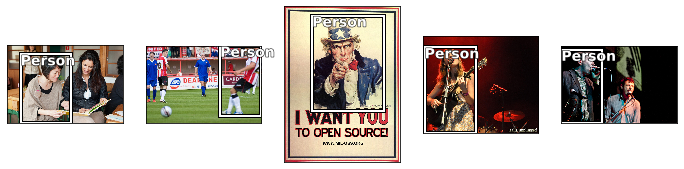

# of labels = 29935
Selected balance so far = {'Car': 6278, 'Person': 23657}


In [7]:
ids = image_ids(od.anno_df[(0.3 < od.anno_df.Size) & (od.anno_df.Size < 0.4)])
df = od.anno_df[od.anno_df.ImageID.isin(ids)]
od.dataset(df=df[:5]).show(range(5), matrixsize=(5,1), figsize=(12, 8))
print(f'# of labels = {len(ids)}')
print_class_balance('Selected balance so far', df.Label)

### Apply filtering

In [8]:
# Filter by 0.3 <= size < 0.4
od.filter_by_size_(thresh_min=0.3, thresh_max=0.4)
print(f'# of labels = {len(od)}')

# of labels = 29935


### Remove IsGroupOf, IsInside items

We still have some labels such as group of people or image taken from inside of car.

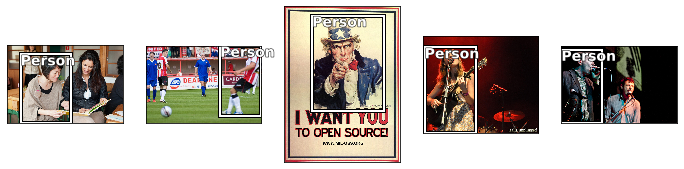

# of labels = 25507
Selected balance so far = {'Car': 5642, 'Person': 19865}


In [9]:
df = od.anno_df[(od.anno_df.IsGroupOf == 0) & (od.anno_df.IsInside == 0)]
od.dataset(df=df[:5]).show(range(5), matrixsize=(5,1), figsize=(12, 8))
print(f'# of labels = {len(df)}')
print_class_balance('Selected balance so far', df.Label)

In [10]:
# Apply this filtreing, by updating annotation dataset manually
od.anno_df = df

### Create subset

This resizes and saves __many images__, will __takes 20+ minutes__ depending on your environment.

In [11]:
od.brew_subset(new_anno_csv=PATH/'annotations.csv',
               dest_folder=PATH/'images', resize_shape=(640,640))

100%|██████████| 25507/25507 [26:39<00:00, 15.95it/s]


Now annotations.csv and resized images are both created under PATH.

## Load subset and check

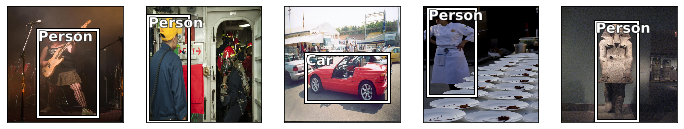

In [12]:
# Load dataframe based object
od = ODAnno(PATH/'annotations.csv', PATH/'images')

# Convert it to dataset
data = od.dataset()

# Show some data
data.show(range(100, 100+5), matrixsize=(5, 1), figsize=(12,6))

## Convert to fast.ai library (v0.7) compatible CSV files

In [13]:
# Nessesory variables: filenames, ids, categories
trn_fns = {str(Path(x).stem):x for x in data.X}
trn_ids = [str(Path(x).stem) for x in data.X]
cats = od.classes

# Nessesory variables: annotation dictionary
def hw_bb(bb): return np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])

trn_anno = collections.defaultdict(lambda:[])
for i, o in enumerate(data.y):
    bb = hw_bb(o[0][:4])
    trn_anno[trn_ids[i]].append((bb, o[0][4]))
len(trn_anno), trn_anno[trn_ids[0]]

(25507, [(array([ 73.75488,  74.4    , 638.40544, 353.     ]), 1)])

In [14]:
# Paths for CSV files
HOME = PATH/'tmp'
ensure_folder(HOME)
CSV = HOME/'lrg.csv'
BB_CSV = HOME/'bb.csv'
JPEGS = 'images'

# Make classification CSV
df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids],
    'cat': [cats[trn_anno[o][0][1]] for o in trn_ids]}, columns=['fn','cat'])
df_to_csv_excel_friendly(df, CSV, index=False)

# Make bounding box CSV
bb = np.array([trn_anno[o][0][0] for o in trn_ids])
bbs = [' '.join(str(p) for p in o) for o in bb]

df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids], 'bbox': bbs}, columns=['fn','bbox'])
df_to_csv_excel_friendly(df, BB_CSV, index=False)

### Borrowing from fast.ai pascal notebook

    **** MAKE SURE OLD fast.ai is ready. ****
    ```sh
    ln -s /your/fastai/old/fastai .
    ```

In [15]:
from fastai.conv_learner import *
from fastai.dataset import *

torch.cuda.set_device(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [16]:
# Model, image size 224x224, batch size
f_model = resnet18
sz=224
bs=64

# For test/validation split
val_idxs = get_cv_idxs(len(trn_fns))

# Raw dataset 1: Classification data source
md2 = ImageClassifierData.from_csv(PATH, JPEGS, CSV, tfms=tfms_from_model(f_model, sz))

# Raw dataset 2: Bounding box data source with bunch of augmentations
augs = [RandomFlip(tfm_y=TfmType.COORD),
        RandomRotate(30, tfm_y=TfmType.COORD),
        RandomLighting(0.1,0.1, tfm_y=TfmType.COORD)]

tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=augs)
md = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, tfms=tfms,
   bs=bs, continuous=True, val_idxs=val_idxs)

# Mixed dataset
class ConcatLblDataset(Dataset):
    def __init__(self, ds, y2): self.ds,self.y2 = ds,y2
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x, (y,self.y2[i]))
trn_ds2 = ConcatLblDataset(md.trn_ds, md2.trn_y)
val_ds2 = ConcatLblDataset(md.val_ds, md2.val_y)

# Now putting everything in `md`
md.trn_dl.dataset = trn_ds2
md.val_dl.dataset = val_ds2

In [17]:
# Checking bounding box sample
x,y=next(iter(md.val_dl))
idx=3
ima=md.val_ds.ds.denorm(to_np(x))[idx]
b = bb_hw(to_np(y[0][idx])); b

array([104.,  33.,  99., 190.])

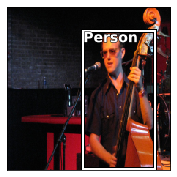

In [18]:
# Visualizing it
ax = show_image(ima, figsize=(3, 3))
ax_draw_bbox(ax, b, md2.classes[y[1][idx]])

## Model and learner

In [19]:
# Model definition
head_reg4 = nn.Sequential(
    Flatten(),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(25088, 256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    nn.Linear(256,4+len(cats)),
)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)

# Optimizer
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam

In [20]:
# Loss
def detn_loss(input, target):
    bb_t,c_t = target
    bb_i,c_i = input[:, :4], input[:, 4:]
    bb_i = F.sigmoid(bb_i)*224
    # I looked at these quantities separately first then picked a multiplier
    #   to make them approximately equal
    return F.l1_loss(bb_i, bb_t) + F.cross_entropy(c_i, c_t)*20

def detn_l1(input, target):
    bb_t,_ = target
    bb_i = input[:, :4]
    bb_i = F.sigmoid(bb_i)*224
    return F.l1_loss(V(bb_i),V(bb_t)).data

def detn_acc(input, target):
    _,c_t = target
    c_i = input[:, 4:]
    return accuracy(c_i, c_t)

learn.crit = detn_loss
learn.metrics = [detn_acc, detn_l1]

 83%|████████▎ | 265/319 [01:10<00:25,  2.12it/s, loss=108] 

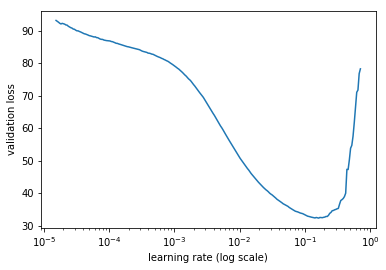

In [21]:
# Find learning rate
learn.lr_find()
learn.sched.plot()

In [22]:
lr=1e-2
learn.fit(lr, 1, cycle_len=3, use_clr=(32,5))

epoch      trn_loss   val_loss   detn_acc   detn_l1         
    0      20.535298  20.730626  0.980396   19.664664 
    1      19.420478  18.478662  0.980984   17.418226       
    2      18.403782  18.063409  0.981768   17.019101       


[18.063409406328827, 0.9817682807292688, 17.0191008738503]

In [ ]:
def visualize_result():
    y = learn.predict()
    x,_ = next(iter(md.val_dl))
    from scipy.special import expit

    for i,ax in enumerate(subplot_matrix(rows=3, columns=4, figsize=(12, 6))):
        ima = md.val_ds.ds.denorm(to_np(x))[i]
        bb = expit(y[i][:4])*224
        b = bb_hw(bb)
        c = np.argmax(y[i][4:])
        ax = show_image(ima, ax=ax)
        ax_draw_bbox(ax, b, md2.classes[c])
    plt.tight_layout()

visualize_result()

After training 3 epochs, it works so so. Training more

 76%|███████▌  | 241/319 [01:08<00:38,  2.05it/s, loss=51.5]

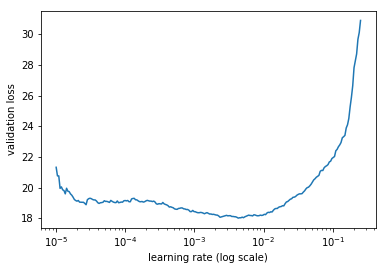

In [24]:
learn.freeze_to(-2)
lrs = np.array([lr/100, lr/10, lr])
learn.lr_find(lrs/1000)
learn.sched.plot(0)

In [25]:
learn.fit(lrs/5, 1, cycle_len=5, use_clr=(32,10))

epoch      trn_loss   val_loss   detn_acc   detn_l1         
    0      16.5664    15.644498  0.983141   14.549822 
    1      15.122431  14.271659  0.983729   13.360149       
    2      13.839859  13.517274  0.985885   12.717438       
    3      12.951263  13.396146  0.987846   12.610218       
    4      12.371089  13.001451  0.988434   12.300389       


[13.001451213367778, 0.9884336404626544, 12.300388754781286]

In [ ]:
visualize_result()

In [27]:
learn.unfreeze()
learn.fit(lrs/20, 1, cycle_len=10, use_clr=(32,10))

epoch      trn_loss   val_loss   detn_acc   detn_l1         
    0      12.419804  13.15835   0.986473   12.311093 
    1      12.11909   12.995574  0.986865   12.21662        
    2      11.656402  13.100601  0.987061   12.271364       
    3      11.311219  13.04559   0.987061   12.173588       
    4      11.356771  12.919652  0.987649   12.049293       
    5      10.935745  12.880977  0.986865   11.894147       
    6      10.622359  12.81952   0.987649   11.89322        
    7      10.522791  12.9025    0.988042   12.045821       
    8      10.51362   12.902638  0.988042   11.953766       
    9      10.474202  12.783754  0.988238   11.88888        


[12.783754010921225, 0.988237600470496, 11.888880120752091]

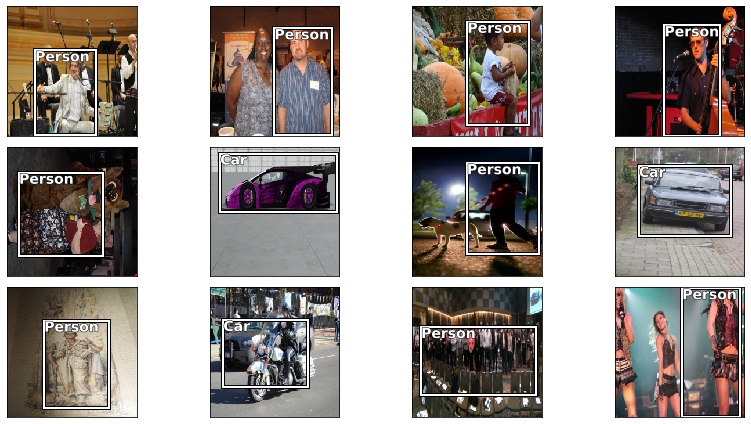

In [28]:
visualize_result()